In [1]:
# Value Iteration for PIMDP Reachability Checking
# Jesse Jiang

# Import classes
import numpy as np

# Class for PIMDP state
class State:

  # Constructor Method
  def __init__(self, id, actions, lower, upper, stateType):
    # Set state ID
    self.id = id
    # Possible actions
    self.actions = actions
    # Lower transition bounds for each action
    # Dictionary format for each action, {nextState:transitionProb}
    self.lower = [lower[x] for x in range(len(actions))]
    # Upper transition bounds for each action
    self.upper = [upper[x] for x in range(len(actions))]
    # Accepting = 'a', Rejecting = 'r', Uncertain = 'u'
    self.stateType = stateType
    # Initial probability of satisfying specification
    # 1 if accepting, 0 if rejecting or uncertain
    if stateType == 'a':
      self.psat = 1
    else:
      self.psat = 0

  # Return state id
  def getID(self):
    return self.id

  # Append a new action
  def append(self, action, lower, upper):
    self.actions.append(action)
    self.lower.append(lower)
    self.upper.append(upper)

  # Remove an action
  def remove(self, action):
    idx = self.actions.index(action)
    self.actions.pop(idx)
    self.lower.pop(idx)
    self.upper.pop(idx)

  # Return probability of satisfying specification
  def getPSat(self):
    return self.psat

  # Return set of actions
  def getActions(self):
    return self.actions

  # Return lower transition probabilities for an action
  def getLower(self, action):
    idx = self.actions.index(action)
    return self.lower[idx]

  # Return upper transition probabilities for an action
  def getUpper(self, action):
    idx = self.actions.index(action)
    return self.upper[idx]
  
  # Return next states for a given action
  def getNext(self, action):
    idx = self.actions.index(action)
    return self.lower[idx].keys()

  # Set state type
  def setStateType(self, stateType):
    self.stateType = stateType

  # Update transition probability
  def update(self, action, lower, upper):
    idx = self.actions.index(action)
    self.lower[idx] = lower
    self.upper[idx] = upper

  # Set probability of satisfying specification
  def setPSat(self, psat):
    self.psat = psat

  # Set optimal control action
  def setOptAct(self, action):
    self.optimalAction = action

  # Get state type
  def getStateType(self):
    return self.stateType

  # Print info
  def getInfo(self):
    print("State ID: " + str(self.id))
    for action in self.actions:
      idx = self.actions.index(action)
      print("Action " + action + "\nLower Transitions: ")
      print(self.lower[idx])
      print("Upper Transitions: ")
      print(self.upper[idx])
      print("\n")

  # Get optimal control action
  def getOptAct(self):
    return self.optimalAction

# Class for PIMDP State Space
class StateSpace:

  # Constructor Method
  def __init__(self, states):
    # Initialize state
    self.states = states
    # Initialize state IDs
    self.ids = []
    for state in states:
      self.ids.append(state.getID())
    # Initialize set of all actions
    self.actions = []
    self.lowers = []
    self.uppers = []
    self.psats = []
  # Append State
  def append(self, state):
    self.states.append(state)
    self.ids.append(state.getID())

  # Remove State
  def remove(self, state):
    self.states.remove(state)
    self.ids.remove(state.getID())

  # Find all feasible actions
  def findActions(self):
    # Loop through all states
    self.actions=[]
    for state in self.states:
      # get actions
      tempActions = state.getActions()
      for action in tempActions:
        # append new actions
        if action not in self.actions:
          self.actions.append(action)

  # Find number of uncertain states
  def countUncertain(self):
    self.numUncertain = 0
    for state in self.states:
      if state.getStateType() == 'u':
        self.numUncertain = self.numUncertain + 1

  # Construct Lower and Upper Transition Probability Matrix
  def constructTransitions(self):
    self.lowers = []
    self.uppers = []
    # Create one transition matrix for each action
    for action in self.actions:
      tempLower = np.zeros([len(self.states),len(self.states)])
      tempUpper = np.zeros([len(self.states),len(self.states)])
      # Loop through states
      for state in self.states:
        id = state.getID()
        # Append transition probabilities if applicable
        if action in state.getActions():
            next = state.getNext(action)
            lower = state.getLower(action)
            upper = state.getUpper(action)
            for ns in next:
              tempLower[ns,id] = lower.get(ns)
              tempUpper[ns,id] = upper.get(ns)
      self.lowers.append(tempLower)
      self.uppers.append(tempUpper)

  # Construct vector of PSats
  def getPSats(self):
    self.psats=np.empty([len(self.states),1])
    # Loop through states and append PSats
    for state in range(len(self.states)):
      self.psats[state] = self.states[state].getPSat()

  # Construct list of optimal actions
  def getOptActs(self):
    self.optActs=[]
    # Loop through states and append PSats
    for state in self.states:
      self.optActs.append(state.getOptAct())

  # Order states
  def orderStates(self):
    self.getPSats()
    # Return states ordered from lowest PSat to highest
    return np.argsort(self.psats,axis=0)

  # Construct minimizing transition matrix based on state ordering
  def orderMinTransitions(self):
    self.orderedTransitions = []
    # Sort states from lowest to highest PSat
    self.order = self.orderStates()
    # Loop through each transition matrix
    for act in range(len(self.actions)):
      lower = self.lowers[act]
      upper = self.uppers[act]
      tempMat = np.zeros([len(self.states),len(self.states)])
      # Loop through each row
      for col in range(len(self.states)):
        # Loop through each potential ordering
        self.remainder = 0
        for i in range(len(self.states)):
          self.remainder = 0
          # Add appropriate lower and upper probabilities
          probs = np.sum(upper[self.order[0:i],col]) + np.sum(lower[self.order[i+1:],col])
          # Check if remainder is a valid probability
          diff = 1-probs
          if ((diff<=upper[self.order[i],col]) and (diff>=lower[self.order[i],col])):
            self.remainder = diff
            break
        # Assign final transition probabilities
        tempMat[self.order[0:i],col] = upper[self.order[0:i],col]
        tempMat[self.order[i+1:],col] = lower[self.order[i+1:],col]
        tempMat[self.order[i],col] = self.remainder
      # Construct final matrix for given action
      self.orderedTransitions.append(tempMat)


  # Construct maximizing transition matrix based on state ordering
  def orderMaxTransitions(self):
    self.orderedTransitions = []
    # Sort states from lowest to highest PSat
    self.order = self.orderStates()
    self.order = self.order[::-1]
    # Loop through each transition matrix
    for act in range(len(self.actions)):
      lower = self.lowers[act]
      upper = self.uppers[act]
      tempMat = np.zeros([len(self.states),len(self.states)])
      # Loop through each row
      for col in range(len(self.states)):
        # Loop through each potential ordering
        self.remainder = 0
        for i in range(len(self.states)):
          self.remainder = 0
          # Add appropriate lower and upper probabilities
          probs = np.sum(upper[self.order[0:i],col]) + np.sum(lower[self.order[i+1:],col])
          # Check if remainder is a valid probability
          diff = 1-probs
          if ((diff<=upper[self.order[i],col]) and (diff>=lower[self.order[i],col])):
            self.remainder = diff
            break
        # Assign final transition probabilities
        tempMat[self.order[0:i],col] = upper[self.order[0:i],col]
        tempMat[self.order[i+1:],col] = lower[self.order[i+1:],col]
        tempMat[self.order[i],col] = self.remainder
      # Construct final matrix for given action
      self.orderedTransitions.append(tempMat)


  # Perform a single iteration of algorithm
  def iterate(self):
    pTrans = np.zeros([len(self.states),len(self.actions)])
    # Do matrix-vector multiplication for each action
    for act in range(len(self.actions)):
      pTrans[:,act] = np.squeeze(np.transpose(self.orderedTransitions[act]) @ self.psats)
    # Maximize PSat for each state
    i=0
    for state in self.states:
      # Find valid actions
      idx = []
      for act in state.getActions():
        idx.append(self.actions.index(act))
      # Maximize PSats
      val = np.amax(pTrans[i,idx],axis=0)
      state.setPSat(np.amax(pTrans[i,idx],axis=0))
      idx = np.nonzero(pTrans[i,idx]==val)[0]
      acts = []
      for j in idx:
        acts.append(state.getActions()[j])
      state.setOptAct(acts)
      i=i+1
    return self.psats

  # Repeat value iteration until condition is met
  def valueIterationMin(self):
    # Find all available actions
    self.findActions()
    # Construct upper and lower transition matrices
    self.constructTransitions()
    # Get initial PSats
    self.getPSats()
    i = 0
    #print("Iteration " + str(i))
    #print(self.psats)
    oldPsats = self.psats
    # Construct ordered transition matrix
    self.orderMinTransitions()
    # Perform iteration
    self.iterate()
    self.getPSats()
    i=i+1
    # While probabilities are not steady state
    while(np.amax(np.abs(oldPsats-self.psats))>0.01):
      #print("Iteration " + str(i))
      #print(self.psats)
      oldPsats = self.psats
      # Iterate
      self.orderMinTransitions()
      self.iterate()
      self.getPSats()
      i=i+1
    # Once probabilities are set, get optimal actions for each state
    self.getOptActs()
    #print("Optimal Actions: ")
    #print(self.optActs)

  # Repeat value iteration until condition is met
  def valueIterationMax(self):
    # Find all available actions
    self.findActions()
    # Construct upper and lower transition matrices
    self.constructTransitions()
    # Get initial PSats
    self.getPSats()
    i = 0
    #print("Iteration " + str(i))
    #print(self.psats)
    oldPsats = self.psats
    # Construct ordered transition matrix
    self.orderMaxTransitions()
    # Perform iteration
    self.iterate()
    self.getPSats()
    i=i+1
    # While probabilities are not steady state
    while(np.amax(np.abs(oldPsats-self.psats))>0.01):
      #print("Iteration " + str(i))
      #print(self.psats)
      oldPsats = self.psats
      # Iterate
      self.orderMaxTransitions()
      self.iterate()
      self.getPSats()
      i=i+1
    # Once probabilities are set, get optimal actions for each state
    self.getOptActs()
    #print("Optimal Actions: ")
    #print(self.optActs)

  # Print states
  def getInfo(self):
    print("State Space\n")
    for state in self.states:
      state.getInfo()

In [2]:
# Gaussian Process Setup
import math

class GaussianProcess:

  # Constructor Method
  def __init__(self):
    # Initialize variance such that all known g(x) are within one standard deviation
    self.variance = 0.45**2
    # Initialize length
    self.l = 1.75
    # Initialize Data Points
    self.pos = np.empty((2,0))
    self.val = np.empty((1,0))
    # Initialize stochastic noise variance
    self.noiseVariance = 0.1 ** 2
    self.ZZ = []
  
  # Add Data Samples
  def append(self,pos,val):
    # Append coordinate position
    self.pos = pos
    # Append g(x) value
    self.val = val

  # Construct Correlation Matrix
  def correlation(self, X1, X2):
    # Initialize correlation matrix
    K = np.zeros((X1.shape[1], X2.shape[1]))
    # Loop through all matrix entries
    for i in np.arange(X1.shape[1]):
      for j in np.arange(X2.shape[1]):
        K[i,j] = self.variance*math.exp(-(np.linalg.norm(X1[:,i]-X2[:,j])**2)/(2*self.l**2))
    return K
  
  # Calculate correlations
  def train(self):
    self.ZZ = np.linalg.inv(self.correlation(self.pos,self.pos)+self.noiseVariance*np.identity(self.pos.shape[1]))

  # Calculate predicted mean at a point
  def calcMean(self,pos):
    # edge case with no samples
    if self.pos.shape[1] == 0:
      return np.array([[0]])
    return self.correlation(pos,self.pos)@self.ZZ@self.val.T

  # Calculate predicted variance at a point
  def calcVariance(self, pos):
    # edge case with no samples
    if self.pos.shape[1] == 0:
      return np.array([[self.variance]])
    return self.correlation(pos,pos)-self.correlation(pos,self.pos)@self.ZZ@self.correlation(self.pos,pos)

In [3]:
# Gaussian Process Setup for True Dynamics
import math

class GaussianProcessTrue:

  # Constructor Method
  def __init__(self):
    # Initialize variance such that all known g(x) are within one standard deviation
    self.variance = 0.45**2
    # Initialize length
    self.l = 1.75
    # Initialize Data Points
    self.pos = np.empty((2,0))
    self.val = np.empty((1,0))
    self.ZZ = []
  
  # Add Data Samples
  def append(self,pos,val):
    # Append coordinate position
    self.pos = pos
    # Append g(x) value
    self.val = val

  # Construct Correlation Matrix
  def correlation(self, X1, X2):
    # Initialize correlation matrix
    K = np.zeros((X1.shape[1], X2.shape[1]))
    # Loop through all matrix entries
    for i in np.arange(X1.shape[1]):
      for j in np.arange(X2.shape[1]):
        K[i,j] = self.variance*math.exp(-(np.linalg.norm(X1[:,i]-X2[:,j])**2)/(2*self.l**2))
    return K
  
  # Calculate correlations
  def train(self):
    self.ZZ = np.linalg.inv(self.correlation(self.pos,self.pos))

  # Calculate predicted mean at a point
  def calcMean(self,pos):
    # edge case with no samples
    if self.pos.shape[1] == 0:
      return np.array([[0]])
    return self.correlation(pos,self.pos)@self.ZZ@self.val.T

  # Calculate predicted variance at a point
  def calcVariance(self, pos):
    # edge case with no samples
    if self.pos.shape[1] == 0:
      return np.array([[self.variance]])
    return self.correlation(pos,pos)-self.correlation(pos,self.pos)@self.ZZ@self.correlation(self.pos,pos)

In [4]:
# Sparse Gaussian Process
# Code by Martin Krasser
import jax.numpy as jnp
import jax.scipy as jsp

from jax import random, jit, value_and_grad
from jax.config import config
from scipy.optimize import minimize

config.update("jax_enable_x64", True)

class SparseGaussianProcess:

    # Constructor Method
  def __init__(self):
    # Initialize variance such that all known g(x) are within one standard deviation
    self.variance = (0.45)**2
    # Initialize length
    self.l = 1.75
    # Initialize Data Points
    self.pos = np.empty((2,0))
    self.val = np.empty((1,0))
    # Initialize stochastic noise variance
    self.noiseVariance = 0.1 ** 2
    self.noiseStd = 0.1
    self.ZZ = []
    # Initialize number of inducing variables
    self.m = 250
    self.theta_opt = []
  
  # Add Data Samples
  def append(self,pos,val):
    # Append coordinate position
    self.pos = pos
    # Append g(x) value
    self.val = val

  def calcMean(self,pos):
    # edge case with no samples
    if self.pos.shape[1] == 0:
      return np.array([[0]])
    f_test, f_test_cov = q(pos.T, self.theta_opt, self.X_m_opt, self.mu_m_opt, self.A_m_opt, self.K_mm_inv)
    return f_test

  def calcVariance(self,pos):
    # edge case with no samples
    if self.pos.shape[1] == 0:
      return np.array([[self.variance]])
    f_test, f_test_cov = q(pos.T, self.theta_opt, self.X_m_opt, self.mu_m_opt, self.A_m_opt, self.K_mm_inv)
    f_test_var = np.diag(f_test_cov)
    f_test_std = np.sqrt(f_test_var) 
    return f_test_var

  def correlation(self, X1, X2):
    # Initialize correlation matrix
    K = np.zeros((X1.shape[1], X2.shape[1]))
    # Loop through all matrix entries
    for i in np.arange(X1.shape[1]):
      for j in np.arange(X2.shape[1]):
        K[i,j] = self.variance*math.exp(-(np.linalg.norm(X1[:,i]-X2[:,j])**2)/(2*self.l**2))
    return K
  
  def train(self):
    # Optimized kernel parameters and inducing inputs
    #self.theta_opt, self.X_m_opt = opt(self.pos,self.val,self.m,self.noiseStd)
    self.X_m_opt = opt(self.pos,self.val,self.m,self.noiseStd)
    self.mu_m_opt, self.A_m_opt, self.K_mm_inv = phi_opt(self.theta_opt, self.X_m_opt, self.pos.T, self.val.T, self.noiseStd)

In [5]:
# Sparse Gaussian Process Methods

# Kernel hyperparameters (length,standard deviation)
theta_fixed = jnp.array([1.75,0.45])
def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m, d).
        X2: Array of n points (n, d).
        theta: kernel parameters (2,)
    """

    sqdist = jnp.sum(X1 ** 2, 1).reshape(-1, 1) + jnp.sum(X2 ** 2, 1) - 2 * jnp.dot(X1, X2.T)
    return theta[1] ** 2 * jnp.exp(-0.5 / theta[0] ** 2 * sqdist)


def kernel_diag(d, theta):
    """
    Isotropic squared exponential kernel (computes diagonal elements only).
    """
    return jnp.full(shape=d, fill_value=theta[1] ** 2)

def jitter(d, value=1e-6):
    return jnp.eye(d) * value


def softplus(X):
    return jnp.log(1 + jnp.exp(X))


def softplus_inv(X):
    return jnp.log(jnp.exp(X) - 1)


def pack_params(theta, X_m):
    return jnp.concatenate([softplus_inv(theta), X_m.ravel()])


def unpack_params(params):
    return softplus(params[:2]), jnp.array(params[2:].reshape(-1, 2))


def nlb_fn(X, y, sigma_y):
    n = X.shape[0]

    def nlb(params):
        """
        Negative lower bound on log marginal likelihood.
        
        Args:
            params: kernel parameters `theta` and inducing inputs `X_m`
        """
        
        theta, X_m = unpack_params(params)
        K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
        K_mn = kernel(X_m, X, theta)

        L = jnp.linalg.cholesky(K_mm)  # m x m
        A = jsp.linalg.solve_triangular(L, K_mn, lower=True) / sigma_y # m x n        
        AAT = A @ A.T  # m x m
        B = jnp.eye(X_m.shape[0]) + AAT  # m x m
        LB = jnp.linalg.cholesky(B)  # m x m
        c = jsp.linalg.solve_triangular(LB, A.dot(y), lower=True) / sigma_y  # m x 1

        # Equation (13)
        lb = - n / 2 * jnp.log(2 * jnp.pi)
        lb -= jnp.sum(jnp.log(jnp.diag(LB)))
        lb -= n / 2 * jnp.log(sigma_y ** 2)
        lb -= 0.5 / sigma_y ** 2 * y.T.dot(y)
        lb += 0.5 * c.T.dot(c)
        lb -= 0.5 / sigma_y ** 2 * jnp.sum(kernel_diag(n, theta))
        lb += 0.5 * jnp.trace(AAT)

        return -lb[0, 0]

    # nlb_grad returns the negative lower bound and 
    # its gradient w.r.t. params i.e. theta and X_m.
    nlb_grad = jit(value_and_grad(nlb))

    def nlb_grad_wrapper(params):
        value, grads = nlb_grad(params)
        # scipy.optimize.minimize cannot handle
        # JAX DeviceArray directly. a conversion
        # to Numpy ndarray is needed.
        return np.array(value), np.array(grads)

    return nlb_grad_wrapper

  # Run optimization
def opt(pos,val,m,noiseStd):
  # Initialize inducing inputs
  indices = jnp.floor(jnp.linspace(0,pos.shape[1]-1,m)).astype(int)
  X_m = jnp.array(pos.T[indices,:])
  res = minimize(fun=nlb_fn(pos.T, val.T, noiseStd),
                  x0=pack_params(jnp.array([1.0, 1.0]), X_m),
                  method='L-BFGS-B',
                  jac=True)

    # Optimized kernel parameters and inducing inputs
  theta_opt, X_m_opt = unpack_params(res.x)
  return X_m_opt  

@jit
def phi_opt(theta, X_m, X, y, sigma_y):
  theta = theta_fixed
  """Optimize mu_m and A_m using Equations (11) and (12)."""
  precision = (1.0 / sigma_y ** 2)

  K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
  K_mm_inv = jnp.linalg.inv(K_mm)
  K_nm = kernel(X, X_m, theta)
  K_mn = K_nm.T
    
  Sigma = jnp.linalg.inv(K_mm + precision * K_mn @ K_nm)
    
  mu_m = precision * (K_mm @ Sigma @ K_mn).dot(y)
  A_m = K_mm @ Sigma @ K_mm    
  
  return mu_m, A_m, K_mm_inv


@jit
def q(X_test, theta, X_m, mu_m, A_m, K_mm_inv):
  """
  Approximate posterior. 
    
  Computes mean and covariance of latent 
  function values at test inputs X_test.
  """
  theta = theta_fixed
  K_ss = kernel(X_test, X_test, theta)
  K_sm = kernel(X_test, X_m, theta)
  K_ms = K_sm.T

  f_q = (K_sm @ K_mm_inv).dot(mu_m)
  f_q_cov = K_ss - K_sm @ K_mm_inv @ K_ms + K_sm @ K_mm_inv @ A_m @ K_mm_inv @ K_ms
    
  return f_q, f_q_cov







In [6]:
# Python program to find strongly connected components in a given
# directed graph using Tarjan's algorithm (single DFS)
#Complexity : O(V+E)
#Author: GeeksForGeeks
  
from collections import defaultdict
  
#This class represents an directed graph
# using adjacency list representation
class Graph:
  
    def __init__(self,vertices):
        #No. of vertices
        self.V = vertices
         
        # default dictionary to store graph
        self.graph = defaultdict(list)
         
        self.Time = 0
        self.sccs = []
  
    # function to add an edge to graph
    def addEdge(self,u,v):
        self.graph[u].append(v)
         
  
    '''A recursive function that find finds and prints strongly connected
    components using DFS traversal
    u --> The vertex to be visited next
    disc[] --> Stores discovery times of visited vertices
    low[] -- >> earliest visited vertex (the vertex with minimum
                discovery time) that can be reached from subtree
                rooted with current vertex
     st -- >> To store all the connected ancestors (could be part
           of SCC)
     stackMember[] --> bit/index array for faster check whether
                  a node is in stack
    '''
    def SCCUtil(self,u, low, disc, stackMember, st):
 
        # Initialize discovery time and low value
        disc[u] = self.Time
        low[u] = self.Time
        self.Time += 1
        stackMember[u] = True
        st.append(u)

        # Go through all vertices adjacent to this
        for v in self.graph[u]:
             
            # If v is not visited yet, then recur for it
            if disc[v] == -1 :
             
                self.SCCUtil(v, low, disc, stackMember, st)
 
                # Check if the subtree rooted with v has a connection to
                # one of the ancestors of u
                # Case 1 (per above discussion on Disc and Low value)
                low[u] = min(low[u], low[v])
                         
            elif stackMember[v] == True:
 
                '''Update low value of 'u' only if 'v' is still in stack
                (i.e. it's a back edge, not cross edge).
                Case 2 (per above discussion on Disc and Low value) '''
                low[u] = min(low[u], disc[v])
 
        # head node found, pop the stack and print an SCC
        w = -1 #To store stack extracted vertices
        if low[u] == disc[u]:
            # temp list
            tempList = []
            while w != u:
                w = st.pop()
                # Append to list
                tempList.append(w)
                stackMember[w] = False
                 
            # Append list to main list
            self.sccs.append(tempList)

#The function to do DFS traversal.
    # It uses recursive SCCUtil()
    def SCC(self):
  
        # Mark all the vertices as not visited
        # and Initialize parent and visited,
        # and ap(articulation point) arrays
        disc = [-1] * (self.V)
        low = [-1] * (self.V)
        stackMember = [False] * (self.V)
        st =[]
         
 
        # Call the recursive helper function
        # to find articulation points
        # in DFS tree rooted with vertex 'i'
        for i in range(self.V):
            if disc[i] == -1:
                self.SCCUtil(i, low, disc, stackMember, st)

In [7]:
# Grid World Example Setup

import scipy.stats as stats
import copy

# Initialize random seed for rng
rng = np.random.default_rng(2022)

# Create grid world class
class GridWorld:

  # Create random slopes (between -0.2 and 0.2)
  slopex = rng.integers(low=-2,high=3,size=(1,25)).astype(float)/10
  slopey = rng.integers(low=-2,high=3,size=(1,25)).astype(float)/10

  # Constructor Method
  def __init__(self):
    # Number of states
    self.numStates = 25
    # Initialize position of robot
    self.currentPos = np.array([[0.5],[0.5]])
    # Calculate region centers
    xpos = np.reshape(np.arange(0.5,5,1),(1,5))
    ypos = np.ones((1,5))
    self.centers = np.concatenate((np.concatenate((xpos,xpos,xpos,xpos,xpos),axis=1),np.reshape(xpos.T@ypos,(1,25))),axis=0)
    # Initialize Gaussian Processes for all dimensions
    self.gpX = SparseGaussianProcess()
    self.gpY = SparseGaussianProcess()
    # Initialize Gaussian Processes for true dynamics
    self.gX = GaussianProcessTrue()
    self.gY = GaussianProcessTrue()
    self.gX.append(self.centers, GridWorld.slopex)
    self.gY.append(self.centers, GridWorld.slopey)
    self.gX.train()
    self.gY.train()
    # Initialize stochastic noise
    self.noiseStd = 0.1
    self.noiseVariance = self.noiseStd ** 2
    self.v = stats.truncnorm(-2,2,loc=0,scale=self.noiseStd)
    # Initialize GP training arrays
    self.pos = np.empty((2,0))
    self.val = np.empty((2,0))
    # Set initial state
    self.initState = self.getRegion()
    self.currState = self.initState
    # Set desired probability of satisfaction for goal state
    self.Psat = 1
    # Initialize uncertainty vector
    self.uncertainty = np.empty((1,0))
    # Initialize vector of psats
    self.psats = np.empty((1,0))
    # Initialize error vector
    self.errors = np.empty((1,0))

  # Method to determine current abstraction region
  def getRegion(self):
    # Get x value
    x = np.floor(self.currentPos[0])
    # Get y value
    y = np.floor(self.currentPos[1])
    # Round down if position is exactly 5
    x = np.min(np.concatenate((x.reshape(1,1),np.array([[4]]))))
    y = np.min(np.concatenate((y.reshape(1,1),np.array([[4]]))))
    # Return region
    return int(5*y+x)

  # Method to calculate true unknown dynamics
  def g(self):
    # Get true GP values
    x=self.gX.calcMean(self.getPos())
    x=np.array(min(max(x,-.4),.4)).reshape(1,1)
    y=self.gY.calcMean(self.getPos())
    y=np.array(min(max(y,-.4),.4)).reshape(1,1)
    return np.concatenate((x,y),axis=0).reshape(2,1)

  # Method to calculate true unknown dynamics at arbitrary state
  def g2(self, pos):
    # Get true GP values
    x=self.gX.calcMean(pos)
    x=np.array(min(max(x,-.4),.4)).reshape(1,1)
    y=self.gY.calcMean(pos)
    y=np.array(min(max(y,-.4),.4)).reshape(1,1)
    return np.concatenate((x,y),axis=0).reshape(2,1)
  
  # Method to calculate region of x uncertainty of GP approximation
  def stdx(self, region):
    # Initialize g(x) uncertainty
    maxVar = 0
    # Loop through grid of 100 points in region
    cen = self.getCenter(region)
    for i in np.arange(cen[0]-0.45, cen[0]+0.5, 0.45):
      for j in np.arange(cen[1]-0.45, cen[1]+0.5, 0.45):
        pos = np.array([[i],[j]])
        # Calculate x variance at point
        tempVar = self.gpX.calcVariance(pos)
        # Update max variance
        if tempVar > maxVar:
          maxVar = tempVar
    return maxVar
        
  # Method to calculate region of y uncertainty of GP approximation
  def stdy(self, region):
    # Initialize g(x) uncertainty
    maxVar = 0
    # Loop through grid of 100 points in region
    cen = self.getCenter(region)
    for i in np.arange(cen[0]-0.45, cen[0]+0.5, 0.45):
      for j in np.arange(cen[1]-0.45, cen[1]+0.5, 0.45):
        pos = np.array([[i],[j]])
        # Calculate y variance at point
        tempVar = self.gpY.calcVariance(pos)
        # Update max variance
        if tempVar > maxVar:
          maxVar = tempVar
    return maxVar

  # Method to set the current position
  def setPos(self,pos):
    self.currentPos=pos

  # Method to return the current position
  def getPos(self):
    return self.currentPos.reshape(2,1)

  # Method to return center of region
  def getCenter(self,region):
    return self.centers[:,region].reshape(2,1)

  # Method to simulate a discrete step
  def step(self,target):
    # Calculate controller
    u = self.getCenter(target)-self.getPos()-np.concatenate((self.gpX.calcMean(self.getPos()),self.gpY.calcMean(self.getPos())),axis=0)
    prevPos = self.getPos()
    #print(self.g())
    self.currentPos = self.getPos()+u+self.g()+self.v.rvs(size=2,random_state=rng.integers(2**32-1)).reshape(2,1)
    # Append training samples
    self.pos = np.append(self.pos,prevPos,axis=1)
    self.val = np.append(self.val,(self.getPos()-prevPos-u).reshape(2,1),axis=1)
    # Prevent leaving the boundary of the world
    if self.currentPos[0] > 5:
      self.currentPos[0] = 5
    if self.currentPos[1] > 5:
      self.currentPos[1] = 5
    if self.currentPos[0] < 0:
      self.currentPos[0] = 0
    if self.currentPos[1] < 0:
      self.currentPos[1] = 0

  # Method to train Gaussian processes
  def train(self):
    # Add sample to GP x
    self.gpX.append(self.pos,self.val[0,:].reshape(1,-1))
    # Add sample to GP y
    self.gpY.append(self.pos,self.val[1,:].reshape(1,-1))
    # Perform GP Regression
    ZZ = self.gpX.train()
    ZZ = self.gpY.train()

  # Method to construct states
  def makeStates(self):
    # Initialize 25 states in grid world
    states = []
    ids = np.arange(25)
    self.goals = [14]
    self.hazards = [7,8,9,19]
    for id in ids:
      # Initialize generic states
      tempState = State(id,['l','r','u','d'],[{},{},{},{}],[{},{},{},{}],'u')
      states.append(tempState)
      states[id].setPSat(0)
      # Remove invalid actions
      if id%5==0:
        states[id].remove('l')
      if math.floor(id/5)==0:
        states[id].remove('d')
      if id%5==4:
        states[id].remove('r')
      if math.floor(id/5)==4:
        states[id].remove('u')
      # Assign goal and hazard states
      if id in self.goals:
        states[id].setStateType('a')
        states[id].setPSat(1)
        states[id].actions=['s']
      elif id in self.hazards:
        states[id].setStateType('r')
        states[id].actions=['s']
    # Create State Space
    self.s = StateSpace(states)
    self.calcTransitionProbabilities()

  # Method to calculate transition probabilities 
  def calcTransitionProbabilities(self):
    # Loop through all states in the state space
    for state in self.s.states:
      id = state.getID()
      # Loop through all actions
      for action in state.getActions():
        # Calculate desired next state based on action
        if action == 'l':
          desired = id-1
        elif action == 'd':
          desired = id-5
        elif action == "u":
          desired = id+5
        elif action == "r":
          desired = id+1
        elif action == "s":
          desired = id
        # Initialize transition probability dictionaries
        lowers = {}
        uppers = {}
        # Calculate reachable states 
        std2x = 2*math.sqrt(self.stdx(id))
        std2y = 2*math.sqrt(self.stdy(id))
        limitX = math.ceil(std2x+2*self.noiseStd-0.5)
        limitY = math.ceil(std2y+2*self.noiseStd-0.5)
        # Loop through reachable states
        for x in np.arange(max(-limitX,-(desired%5)),min(limitX+1,5-(desired%5))):
          for y in np.arange(max(-limitY,-math.floor(desired/5)),min(limitY+1,5-math.floor(desired/5))):
            # Calculate state id
            tempID = desired+int(5*y+x)
            # Check for valid state
            if (0<=tempID and tempID<=24):
              # Calculate point in g(x) rectangle to use for lower and upper bounds
              if x>0:
                lowerX = self.v.cdf(0.5+std2x+x)-self.v.cdf(0.5+std2x+(x-1))
                upperX = self.v.cdf(0.5-std2x+x)-self.v.cdf(0.5-std2x+(x-1))
              elif x==0:
                lowerX = self.v.cdf(0.5-std2x)-self.v.cdf(-0.5-std2x)
                upperX = self.v.cdf(0.5)-self.v.cdf(-0.5)
              elif x<0:
                lowerX = self.v.cdf(-0.5-std2x)-self.v.cdf(-0.5-std2x+x)
                upperX = self.v.cdf(-0.5+std2x)-self.v.cdf(-0.5+std2x+x)
              if y>0:
                lowerY = self.v.cdf(0.5+std2y+y)-self.v.cdf(0.5+std2y+(y-1))
                upperY = self.v.cdf(0.5-std2y+y)-self.v.cdf(0.5-std2y+(y-1))
              elif y==0:
                lowerY = self.v.cdf(0.5-std2y)-self.v.cdf(-0.5-std2y)
                upperY = self.v.cdf(0.5)-self.v.cdf(-0.5)
              elif y<0:
                lowerY = self.v.cdf(-0.5-std2y)-self.v.cdf(-0.5-std2y+y)
                upperY = self.v.cdf(-0.5+std2y)-self.v.cdf(-0.5+std2y+y)
              # Add reachable states and transition probabilities
              lowers[tempID] = lowerX*lowerY
              uppers[tempID] = upperX*upperY
          if action=="s":
            lowers={id:1}
            uppers={id:1}
        # Update transition probabilities for each action
        state.update(action,lowers,uppers)
      #state.getInfo()

  # Method to calculate safe subgraph
  def pruneGraph(self):
    # Perform max value iteration
    self.s.valueIterationMax()
    # Create copy of graph to prune
    self.safeSG = copy.deepcopy(self.s)
    # Identify states to prune
    self.hazards = []
    for state in self.safeSG.states:
      if state.getPSat() == 0:
        self.hazards.append(state.getID())
    for id in self.hazards:
      idx = self.safeSG.ids.index(id)
      self.safeSG.remove(self.safeSG.states[idx])
      #print(id)
    #Loop while more states have been added as hazards
    newStates = 1
    while newStates != 0:
      newStates = 0
      # Loop through states
      toRemove = []
      for state in self.safeSG.states:
        # Loop through actions
        toRemoveAct = []
        for action in state.getActions():
          # Get reachable states
          next = state.getNext(action)
          # Check if action transitions to hazard state
          if not (set(next).isdisjoint(self.hazards)):
            #print(str(state.getID())+" "+str(action)+" ")
            #print(next)
            # Remove action
            toRemoveAct.append(action)
        # Remove actions
        for act in toRemoveAct:
          state.remove(act)
        # Check if action set is empty
        if len(state.getActions()) == 0:
          # Prune state and treat it as a hazard
          toRemove.append(state.getID())
          self.hazards.append(state.getID())
          # Remove redundant hazards
          self.hazards = list(set(self.hazards))
          newStates = 1
      for id in toRemove:
        idx = self.safeSG.ids.index(id)
        self.safeSG.remove(self.safeSG.states[idx])

  # Method to calculate MECs of safe subgraph
  def calcMECs(self):
    # Iterate while more actions are being pruned
    newStates = 1
    while newStates != 0:
      newStates = 0
      # Create graph to perform SCC calculations
      self.G = Graph(25)
      # Loop through safe states
      for state in self.safeSG.states:
        # Loop through safe actions
        next = []
        for action in state.getActions():
          # Get reachable states
            next.append(list(state.getNext(action)))
        # Remove redundant reachable states
        next = [n for sublist in next for n in sublist]
        next = list(set(next))
        # Loop through reachable states
        for ns in next:
          # Add a graph edge
          self.G.addEdge(state.getID(),ns)
      # Calculate SCCs
      self.G.SCC()
      self.sccs = self.G.sccs
      # Loop through potential SCCs and filter out extraneous ones
      toRemove = []
      for scc in self.sccs:
        if not (set(scc).isdisjoint(self.hazards)):
            # Remove action
            toRemove.append(scc)
      for el in toRemove:
        self.sccs.remove(el)
      toRemove = []
      # Loop through states in subgraph and remove states/transitions not in SCCs
      sccStates = [i for sublist in self.sccs for i in sublist]
      toRemove = []
      indicator = 1
      # Loop while new states are being removed
      while indicator != 0:
        indicator = 0
        for state in self.safeSG.states:
          # Remove states not in SCCs
          if state.getID() not in sccStates:
            toRemove.append(state)
          else:
            # Prune actions which lead out of the SCC
            for scc in self.sccs:
              toRemoveAct = []
              if state.getID() in scc:
                for action in state.getActions():
                  for ns in state.getNext(action):
                    if ns not in scc:
                      toRemoveAct.append(action)
                      break
              # Remove redundancies
              toRemoveAct = list(set(toRemoveAct))
              for act in toRemoveAct:
                newStates=1
                state.remove(act)
          # Remove states with no actions remaining
          if len(state.getActions())==0:
            toRemove.append(state)
        # Remove redundancies
        toRemove = list(set(toRemove))
        for i in toRemove:
          newStates = 1
          indicator = 1
          self.safeSG.remove(i)
        toRemove = []
      # Assign results
      self.mecs = copy.deepcopy(self.sccs)

  # Method to calculate optimal safe cycle
  def calcOptimalMEC(self):
    self.reachProbs = []
    toRemove = []
    # Loop through MECs
    for mec in self.mecs:
      # Create a copy of the state space to manipulate
      self.tempG = copy.deepcopy(self.s)
      # Loop through states and reassign probability of satisfaction (1 and absorbing if in MEC, 0 otherwise)
      for state in self.tempG.states:
        if state.getID() in mec:
          state.actions = ['s']
          state.lower = [{state.getID():1}]
          state.upper = [{state.getID():1}]
          state.setPSat(1)
          state.setStateType('a')
        else:
          state.setPSat(0)
          state.setStateType('u')
      # Calculate reachability probabilities from initial state
      self.tempG.valueIterationMin()
      # Look for reachability probability of 1
      psat = self.tempG.states[self.initState].getPSat()
      self.reachProbs.append(psat)
      if psat < 1:
        toRemove.append(mec)
    # Check to see if there are any reachable MECs
    if len(self.mecs) - len(toRemove) > 0:
      for tr in toRemove:
        self.mecs.remove(tr)
      self.scores = []
      for mec in self.mecs:
        # Calculate covariance scores for each remaining MEC
        tempScore = 0
        for id in mec:
          tempScore = tempScore + self.gpX.correlation(self.getCenter(id),self.getCenter(self.goals[0]))
        self.scores.append(tempScore)
      # Select MEC with the highest score
      self.optimalMEC = self.mecs[np.argmax(self.scores)]
    else:
      # Optimal MEC is immediately the one with the highest Psat if none are guaranteed to be reachable
      self.optimalMEC = self.mecs[np.argmax(self.reachProbs)]

  # Method to synthesize control policy given calculated optimal MEC
  def synthesize(self):
    self.policy = {}
    # Perform reachability calculations to optimal MEC
    # Create a copy of the state space to manipulate
    self.tempG = copy.deepcopy(self.s)
    # Loop through states and reassign probability of satisfaction (1 and absorbing if in MEC, 0 otherwise)
    for state in self.tempG.states:
      if state.getID() in self.optimalMEC:
        state.actions = ['s']
        state.lower = [{state.getID():1}]
        state.upper = [{state.getID():1}]
        state.setPSat(1)
        state.setStateType('a')
      else:
        state.setPSat(0)
        state.setStateType('u')
    # Calculate reachability probabilities from initial state
    self.tempG.valueIterationMin()
    # Loop through states
    for state in self.s.states:
      # Check if state is in MEC
      if state.getID() in self.optimalMEC:
        # Append all valid actions in MEC
        idx = self.safeSG.ids.index(state.getID())
        self.policy[state.getID()]=(self.safeSG.states[idx].getActions())
      else:
        # Append optimal action
        idx = self.tempG.ids.index(state.getID())
        self.policy[state.getID()]=(self.tempG.states[idx].getOptAct())
        
  # Method to calculate total transition uncertainty
  def calcUncertainty(self):
    # Loop through states
    tempUncertainty = 0
    for state in self.s.states:
      # Loop through actions
      for idx in range(len(state.actions)):
        # Extract lower and upper transition probabilities
        tempLower = state.lower[idx]
        tempUpper = state.upper[idx]
        tempLower = np.asarray(list(tempLower.values()))
        tempUpper = np.asarray(list(tempUpper.values()))
        # Sum and append to array
        tempUncertainty = tempUncertainty + np.sum(tempUpper-tempLower)
    tempUncertainty = tempUncertainty.reshape(-1,1)
    self.uncertainty=np.append(self.uncertainty,tempUncertainty,axis=1)

  # Method to calculate error between unknown dynamics and GP
  def calcError(self):
    # Loop through states
    tempError = 0
    for state in self.s.states:
      # Extract estimated and true dynamics and calculate error
      errorX = np.abs(self.gpX.calcMean(self.getCenter(state.getID()))-self.g2(self.getCenter(state.getID()))[0])
      errorY = np.abs(self.gpY.calcMean(self.getCenter(state.getID()))-self.g2(self.getCenter(state.getID()))[1])
      tempError = tempError + errorX + errorY
    # Append error to history vector
    self.errors = np.append(self.errors,np.asarray(tempError).reshape(-1,1))
      
  # Final method to run entire algorithm
  def run(self):
    # Construct states
    self.makeStates()
    # Calculate uncertainty
    self.calcUncertainty()
    # Calculate error
    self.calcError()
    # Perform min reachability probability value iteration
    self.s.valueIterationMin()
    # Calculate probability of satisfaction from initial state
    psat = self.s.states[self.initState].getPSat()
    self.psats = np.append(self.psats,psat.reshape(-1,1),axis=1)
    print("P_sat: " + str(psat))
    numIterOut = 35
    numIterIn = 250
    counterOut = 0
    # Iterate while successful control policy has not been calculated and max number of iterations has not been reached
    while (counterOut < numIterOut) and (psat<self.Psat):
      print(["Iteration: " + str(counterOut)])
      # Calculate safe subgraph
      self.pruneGraph()
      # Calculate optimal MEC
      self.calcMECs()
      self.calcOptimalMEC()
      print(self.optimalMEC)
      # Synthesize control policy
      self.synthesize()
      print("Policy:")
      print(self.policy)
      # Initialize finite memory controller
      tracker = np.zeros((25))
      # Follow control policy for max number of iterations
      counterIn = 0
      while counterIn < numIterIn:
        # Step in the state space
        self.currState = self.getRegion()
        # Calculate action using finite memory controller
        action = self.policy[self.currState][int(tracker[self.currState]%len(self.policy[self.currState]))]
        tracker[self.currState]=tracker[self.currState]+1
        # Calculate desired next state based on action
        if action == 'l':
          desired = self.currState-1
        elif action == 'd':
          desired = self.currState-5
        elif action == "u":
          desired = self.currState+5
        elif action == "r":
          desired = self.currState+1
        elif action == "s":
          desired = self.currState
        self.step(desired)
        #print(self.currentPos)
        #print(desired)
        #print(self.getRegion())
        counterIn = counterIn + 1
      # Train Gaussian Process
      self.train()
      # Reconstruct transition probabilities
      self.makeStates()
      # Calculate uncertainty
      self.calcUncertainty()
      # Calculate error
      self.calcError()
      self.s.valueIterationMin()
      # Calculate new probability of satisfying the specification
      psat = self.s.states[self.initState].getPSat()
      self.psats = np.append(self.psats,psat.reshape(-1,1),axis=1)
      print("P_sat: " + str(psat))
      self.s.getOptActs()
      print("Optimal Actions:")
      print(self.s.optActs)
      counterOut = counterOut + 1
    print(["Iteration: " + str(counterOut)])
    # Calculate safe subgraph
    self.pruneGraph()
    # Calculate optimal MEC
    self.calcMECs()
    self.calcOptimalMEC()
    print(self.optimalMEC)
    
    for state in self.s.states:
      print("Estimated g(x): " + str(self.gpX.calcMean(self.getCenter(state.getID()))))
      print("Estimated x uncertainty: " + str(math.sqrt(self.stdx(state.getID()))*2))
      print("Estimated g(y): " + str(self.gpY.calcMean(self.getCenter(state.getID()))))
      print("Estimated y uncertainty: " + str(math.sqrt(self.stdy(state.getID()))*2))
      print("Actual g(x): " + str(self.g2(self.getCenter(state.getID()))[0]))
      print("Actual g(y): " + str(self.g2(self.getCenter(state.getID()))[1]))
      state.getInfo()
    return counterOut

In [8]:
# Testing GridWorld state construction
import time
gw = GridWorld()
iterations = np.empty((10))
times = np.empty((10))
uncertainties = []
psats = []
tempPos = np.empty((2,0))
tempVal = np.empty((2,0))
for i in np.arange(10):
    start = time.time()
    iterations[i]=gw.run()
    end = time.time()
    print("Time Elapsed: " + str(end-start))
    times[i]=end-start
    uncertainties.append(gw.uncertainty[0])
    psats.append(gw.psats[0])
    gw.uncertainty = np.empty((1,0))
    gw.psats = np.empty((1,0))
    tempPos = gw.gpX.pos
    gw.gpX.pos=np.empty((2,0))
    gw.gpX.val=np.empty((1,0))
    gw.gpY.pos=np.empty((2,0))
    gw.gpY.val=np.empty((1,0))
    gw.pos=np.empty((2,0))
    gw.val=np.empty((2,0))
print("Average Iterations: " + str(np.average(iterations)))
print("Average Time: " + str(np.average(times)))

P_sat: 0.0
['Iteration: 0']
[21, 20, 16, 15, 11, 10, 6, 5, 1, 0]
Policy:
{0: ['u'], 1: ['l'], 2: ['l', 'r', 'u'], 3: ['l', 'r', 'u'], 4: ['l', 'u'], 5: ['u', 'd'], 6: ['l'], 7: ['s'], 8: ['s'], 9: ['s'], 10: ['u', 'd'], 11: ['l'], 12: ['l', 'r', 'u', 'd'], 13: ['l', 'r', 'u', 'd'], 14: ['s'], 15: ['u', 'd'], 16: ['l'], 17: ['l', 'r', 'u', 'd'], 18: ['l', 'r', 'u', 'd'], 19: ['s'], 20: ['d'], 21: ['l'], 22: ['l', 'r', 'd'], 23: ['l', 'r', 'd'], 24: ['l', 'd']}
P_sat: 0.0
Optimal Actions:
[['r', 'u'], ['l', 'r', 'u'], ['l', 'r', 'u'], ['l', 'r', 'u'], ['l', 'u'], ['r', 'u', 'd'], ['l', 'r', 'u', 'd'], ['s'], ['s'], ['s'], ['r', 'u', 'd'], ['l', 'r', 'u', 'd'], ['l', 'r', 'u', 'd'], ['l', 'r', 'u', 'd'], ['s'], ['r', 'u', 'd'], ['l', 'r', 'u', 'd'], ['l', 'r', 'u', 'd'], ['l', 'r', 'u', 'd'], ['s'], ['r', 'd'], ['l', 'r', 'd'], ['l', 'r', 'd'], ['l', 'r', 'd'], ['l', 'd']]
['Iteration: 1']
[21, 20, 16, 15, 6, 11, 10, 5, 1, 0]
Policy:
{0: ['r', 'u'], 1: ['l'], 2: ['l'], 3: ['l', 'r', 'u'],

<Figure size 432x288 with 0 Axes>

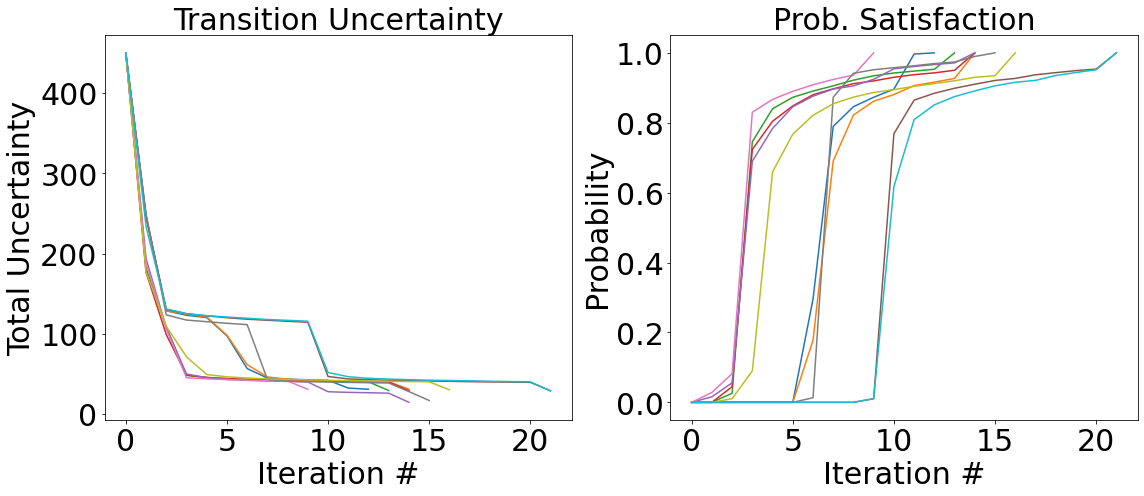

In [26]:
# Plot results
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
f1 = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 7)
fig.tight_layout()
c=0
for col in ax:
    if c==0:
        for i in np.arange(len(uncertainties)):
            col.plot(np.arange(np.size(uncertainties[i],0)),uncertainties[i])
            col.set_title("Transition Uncertainty")
            col.set_xlabel("Iteration #")
            col.set_ylabel("Total Uncertainty")
    if c==1:
        for i in np.arange(len(psats)):
            col.plot(np.arange(np.size(psats[i],0)),psats[i])
            col.set_title("Prob. Satisfaction")
            col.set_xlabel("Iteration #")
            col.set_ylabel("Probability")
    c=1
fig.tight_layout()
for col in ax:
    for item in ([col.title, col.xaxis.label, col.yaxis.label] +
                col.get_xticklabels() + col.get_yticklabels()):
        item.set_fontsize(30)
plt.tight_layout()
fig.savefig("combined_metrics.pdf", bbox_inches='tight')
plt.show()
# Plot error of unknown dynamics estimation
#plt.plot(gw.errors)
#plt.title("Error of Gaussian Process Estimation of Unknown Dynamics")
#plt.xlabel("Iteration #")
#plt.ylabel("Total Error")
#plt.figure()

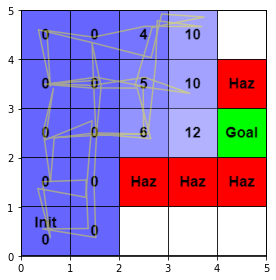

In [10]:
# Plot trajectory
img = plt.imread("safe_grid_casestudy_final.png")
f2 = plt.figure()
plt.imshow(img,extent=[0,5,0,5])
dim = np.size(tempPos,1)
plt.plot(tempPos[0,np.arange(dim-50,dim)],tempPos[1,np.arange(dim-50,dim)],"yellow",alpha=0.4)
f2.tight_layout()
f2.savefig("safe_grid_casestudy.png", bbox_inches='tight', dpi=1000)

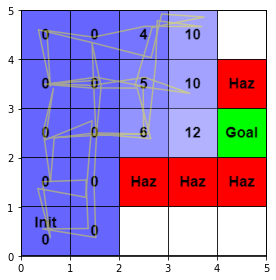

In [12]:
# Plot trajectory
img = plt.imread("safe_grid_casestudy_final.png")
f2 = plt.figure()
plt.imshow(img,extent=[0,5,0,5])
dim = np.size(tempPos,1)
plt.plot(tempPos[0,np.arange(dim-50,dim)],tempPos[1,np.arange(dim-50,dim)],"yellow",alpha=0.4)
f2.tight_layout()
f2.savefig("safe_grid_casestudy.png", bbox_inches='tight', dpi=1000)